#SEGEMENTATION FINISHED

In [ ]:
img_size = 224
img_dir = "dog_training_images/"

In [ ]:
train_gen  = ImageDataGenerator(
    rescale= 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    validation_split = 0.2
)

valid_gen = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2
)

testing_gen = ImageDataGenerator(
    rescale = 1./255
)

In [ ]:
training_df = train_gen.flow_from_directory(
  img_dir,
  subset = "training",
  seed = 42,
  target_size = (img_size, img_size),
  batch_size = 16,
  # class_mode = 'categorical',
  shuffle = True
  )

Found 16508 images belonging to 120 classes.


In [ ]:
validation_df = valid_gen.flow_from_directory(
  img_dir,
  subset = "validation",
  seed = 42,
  target_size = (img_size, img_size),
  batch_size = 16,
  # class_mode = 'categorical',
  shuffle = True
  )

Found 4072 images belonging to 120 classes.


In [ ]:
n_classes = len(training_df.class_indices)

In [ ]:
breeds = training_df.class_indices
breeds = list(breeds.keys())

In [ ]:
train_labels = training_df.classes
print(train_labels)
# train_labels = to_categorical(train_labels, num_classes=n_classes)

val_labels = training_df.classes
# val_labels = to_categorical(val_labels, num_classes=n_classes)

train_labels = preprocess_input(train_labels)
val_labels = preprocess_input(val_labels)

[  0   0   0 ... 119 119 119]


In [ ]:
InceptionV3 = applications.InceptionV3(include_top=False, input_shape=(
    img_size, img_size, 3), weights='imagenet')

87924736/87910968 [==============================] - 0s 0us/step


In [ ]:
model = Sequential()

for layer in InceptionV3.layers:
    layer.trainable = False

model.add(InceptionV3)
model.add(l.GlobalAveragePooling2D())
model.add(l.Dropout(0.2))
model.add(l.Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 120)               245880    
                                                                 
Total params: 22,048,664
Trainable params: 245,880
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
mc = ModelCheckpoint(
    'Inception-base.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto',
    save_weights_only=False,
    period=1
)

es = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode='auto'
)

rlr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

callbacks = [mc, es, rlr]

`period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


In [ ]:
epochs = 20

In [ ]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


In [ ]:
unfreeze_model(model)

hist = model.fit(
    training_df,
    validation_data=validation_df,
    epochs=epochs,
    batch_size=16,
    callbacks=callbacks
)

Epoch 1/20
1032/1032 [==============================] - ETA: 0s - loss: 3.8543 - accuracy: 0.2237
Epoch 1: val_loss improved from inf to 2.05821, saving model to Inception-base.h5
1032/1032 [==============================] - 253s 226ms/step - loss: 3.8543 - accuracy: 0.2237 - val_loss: 2.0582 - val_accuracy: 0.5985 - lr: 1.0000e-05
Epoch 2/20
1032/1032 [==============================] - ETA: 0s - loss: 2.1196 - accuracy: 0.5492
Epoch 2: val_loss improved from 2.05821 to 1.09227, saving model to Inception-base.h5
1032/1032 [==============================] - 227s 220ms/step - loss: 2.1196 - accuracy: 0.5492 - val_loss: 1.0923 - val_accuracy: 0.7284 - lr: 1.0000e-05
Epoch 3/20
1032/1032 [==============================] - ETA: 0s - loss: 1.4739 - accuracy: 0.6436
Epoch 3: val_loss improved from 1.09227 to 0.84644, saving model to Inception-base.h5
1032/1032 [==============================] - 227s 219ms/step - loss: 1.4739 - accuracy: 0.6436 - val_loss: 0.8464 - val_accuracy: 0.7615 - lr: 1

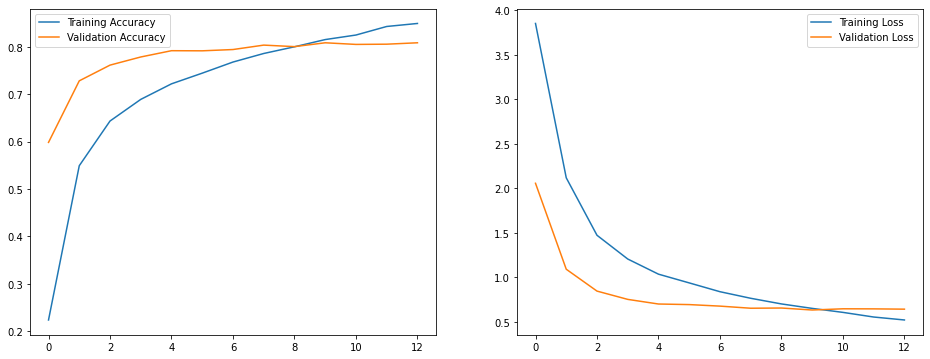

In [ ]:
import matplotlib.pyplot as plt

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs_range = range(13)

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.show()

In [ ]:
def predict_dog_breed(img):
  img = img.resize((img_size, img_size))
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  img = valid_gen(img)
  predictions = model.predict(img)
  score = tf.nn.softmax(predictions[0])
  prediction = breeds[np.argmax(score)]
  confidence = 100 * np.max(score)

  return prediction, confidence

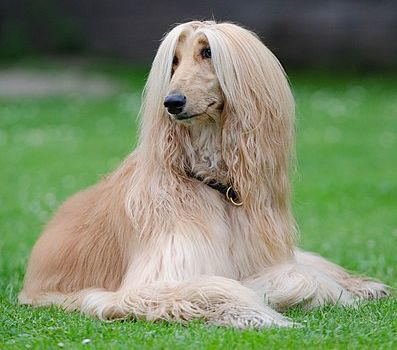

ValueError: ignored

In [ ]:
# img = Image.open(r"dog_training_images/n02085620-Chihuahua/n02085620_10074.jpg")
img = Image.open(r"images/dog_pic.jpg")
display(img)
prediction, confidence = predict_dog_breed(img)
print("Prediction Breed:", prediction[10:])
print("Confidence:", confidence, "%")

